# MNIST Diffusion Model

In this section, we apply the same diffusion model framework to the MNIST dataset. Since MNIST consists
of images, we use convolutional architectures (and residual blocks) for improved performance.

**Key Points:**
- **Architecture:** We use ConvNets with residual connections and a time embedding.
- **Data Loading:** The `generate_mnist` function provides a batch of MNIST images normalized to [-1, 1].
- **Your Task:** Carefully study the architecture and complete the training, reverse process, and sample generation.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torchvision
import math

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


## Data Generation for MNIST

This function downloads MNIST (if not present) and returns a batch of MNIST images with proper normalization:
- **Normalization:** We normalize to [-1, 1] so that the diffusion noise scales work similarly to our previous examples.

In [2]:
def generate_mnist(n_samples=1000):
    """
    Generate MNIST samples, matching the interface of generate_swiss_roll.

    Args:
        n_samples: Number of samples to generate.

    Returns:
        torch.Tensor of shape (n_samples, 1, 28, 28)
    """
    # Define transformation: convert to tensor and normalize to [-1, 1]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Download MNIST dataset if needed
    dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)

    # Create a dataloader to sample n_samples randomly
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=n_samples,
        shuffle=True,
        drop_last=True
    )

    # Get a single batch of images and ignore the labels
    images, _ = next(iter(dataloader))
    return images

# Test the data generator:
# sample_images = generate_mnist(16)
# print(sample_images.shape)  # Expected: [16, 1, 28, 28]


## Time Embedding

We reuse the same time embedding module from the Swiss Roll example.

In [3]:
class TimeEmbedding(nn.Module):
    """Time embedding layer: embeds scalar timesteps into a higher-dimensional space."""
    def __init__(self, dim):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Linear(1, dim),  # Transform from 1 to hidden dimension.
            nn.GELU(),
            nn.Linear(dim, dim),  # Map into final embedding size.
            nn.GELU(),
            nn.Linear(dim, dim)  # Map into final embedding size.

        )

    def forward(self, t):
        t = t.unsqueeze(-1).float()  # Reshape (batch,) -> (batch, 1)
        return self.embed(t)


## Residual Block for ConvNets

This block uses two convolutional layers with BatchNorm and GELU activation. Residual connections (and
proper scaling) are added optionally.


In [4]:
class ResBlock(nn.Module):
    """Residual block with Conv layers for the MNIST diffusion model."""
    def __init__(self, in_c, out_c, is_res=False):
        super().__init__()
        self.is_res = is_res
        self.same_c = in_c == out_c
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),  # Convolution layer
            nn.BatchNorm2d(out_c),
            nn.GELU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.GELU()
        )

    def forward(self, x):
        x1 = self.conv1(x)  # First conv block
        x2 = self.conv2(x1) # Second conv block
        if self.is_res:
            # Use a residual connection
            if self.same_c:
                out = x + x2
            else:
                out = x1 + x2
            return out / math.sqrt(2)  # Scale residual output
        return x2

In [ ]:
class ResBlock(nn.Module):
    """Improved residual block with GroupNorm and more layers."""
    def __init__(self, in_c, out_c, is_res=False):
        super().__init__()
        self.is_res = is_res
        self.same_c = in_c == out_c
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=out_c),  # GroupNorm
            nn.GELU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),  # Extra conv layer
            nn.GroupNorm(num_groups=32, num_channels=out_c),  # GroupNorm
            nn.GELU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=out_c),  # GroupNorm
            nn.GELU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),  # Extra conv layer
            nn.GroupNorm(num_groups=32, num_channels=out_c),  # GroupNorm
            nn.GELU()
        )

    def forward(self, x):
        x1 = self.conv1(x)  # First conv block
        x2 = self.conv2(x1) # Second conv block
        if self.is_res:
            # Use a residual connection
            if self.same_c:
                out = x + x2
            else:
                out = x1 + x2
            return out / math.sqrt(2)  # Scale residual output
        return x2

## Diffusion Model with ConvNets for MNIST

The DiffusionModel below is updated to use convolutional layers, downsampling (via strided convolutions),
and upsampling (using transposed convolutions) along with skip-connections.


In [5]:
class DiffusionModel(nn.Module):
    """Diffusion model for MNIST with ConvNets, residual blocks, and time embedding."""
    def __init__(self, hidden_dim=128):
        super().__init__()

        self.time_embed = TimeEmbedding(hidden_dim)

        # Initial convolution transforms the input image channels into hidden_dim channels.
        self.input_conv = ResBlock(in_c=1, out_c=hidden_dim, is_res=True)

        # Downsampling layers (using convolutions with stride 2)
        self.down1 = nn.Sequential(
            ResBlock(hidden_dim, hidden_dim),
            ResBlock(hidden_dim, hidden_dim),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU()
        )

        self.down2 = nn.Sequential(
            ResBlock(hidden_dim, hidden_dim),
            ResBlock(hidden_dim, hidden_dim),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU()
        )

        # Bottleneck residual block
        self.bottleneck = ResBlock(hidden_dim, hidden_dim, is_res=True)

        # Upsampling with transpose convolutions and skip connections
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
            ResBlock(hidden_dim, hidden_dim, is_res=True),
            ResBlock(hidden_dim, hidden_dim, is_res=True),
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
            ResBlock(hidden_dim, hidden_dim, is_res=True),
            ResBlock(hidden_dim, hidden_dim, is_res=True),
        )

        # Final convolution to map features back to one channel.
        self.output = nn.Conv2d(hidden_dim * 2, 1, 3, padding=1)

    def forward(self, x, t):
        # Compute time embedding and reshape to add spatial dimensions.
        t_emb = self.time_embed(t)
        t_emb = t_emb.view(-1, t_emb.shape[1], 1, 1)

        # Initial convolution with skip connection
        x1 = self.input_conv(x)
        x1 = x1 + t_emb  # Add time information

        # Downsample with added time embedding at each stage.
        x2 = self.down1(x1)
        x2 = x2 + t_emb
        x3 = self.down2(x2)
        x3 = x3 + t_emb

        # Bottleneck transformation
        x3 = self.bottleneck(x3)

        # Upsample, concatenating skip connections.
        x = self.up2(torch.cat([x3, x3], dim=1))  # Using a dummy skip here
        x = self.up1(torch.cat([x, x2], dim=1))

        # Final output using skip connection from input
        x = self.output(torch.cat([x, x1], dim=1))
        return x


## Diffusion Scheduler

This scheduler is identical to our previous example. It defines the forward (diffuse) and reverse processes.


In [6]:
class DiffusionScheduler:
    """Noise scheduler for the diffusion model."""
    def __init__(self, num_timesteps=2000, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device

        # Define a beta schedule linearly spaced between 1e-4 and 0.02
        self.betas = torch.linspace(1e-4, 0.02, num_timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # Precompute useful square roots for the forward process.
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # Additional parameters for the reverse process.
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        alphas_cumprod_prev = torch.cat([torch.ones(1).to(device), self.alphas_cumprod[:-1]])
        self.posterior_variance = self.betas * (1. - alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def diffuse(self, x_0, t):
        """Add noise to the data at timestep t."""
        noise = torch.randn_like(x_0)
        # Reshape scales to match image dimensions
        sqrt_alpha_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        x_t = sqrt_alpha_t * x_0 + sqrt_one_minus_alpha_t * noise
        return x_t, noise

    def reverse_step(self, x_t, t, predicted_noise):
        """Single reverse process step using the provided formula."""
        alpha = self.alphas[t]
        alpha_bar = self.alphas_cumprod[t]
        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = 0
        x_t_minus_1 = (1 / torch.sqrt(alpha)) * (
            x_t - (1 - alpha) / torch.sqrt(1 - alpha_bar) * predicted_noise
        ) + torch.sqrt(self.betas[t]) * noise
        return x_t_minus_1

## Training the MNIST Diffusion Model

In this cell, we define the training loop for the MNIST diffusion model. Notice that the training
procedure is very similar to the Swiss Roll example. The key differences are:
- **Model Architecture:** We use the ConvNet-based DiffusionModel.
- **Data:** We work with 28×28 images which have one channel.

**Your Task:**  
Try to understand the provided code. You are also encouraged to experiment with additional improvements
(e.g., using a learning rate scheduler, customizing loss functions, etc.).

Training Diffusion:   0%|          | 0/10000 [00:00<?, ?it/s]

Failed to download (trying next):
HTTP Error 404: Not Found




  0%|          | 0.00/9.91M [00:00<?, ?B/s]
  1%|          | 65.5k/9.91M [00:00<00:17, 553kB/s]
  3%|▎         | 328k/9.91M [00:00<00:06, 1.51MB/s]
 13%|█▎        | 1.31M/9.91M [00:00<00:01, 4.54MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




  0%|          | 0.00/1.65M [00:00<?, ?B/s]
  4%|▍         | 65.5k/1.65M [00:00<00:02, 556kB/s]
 14%|█▍        | 229k/1.65M [00:00<00:01, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




100%|██████████| 4.54k/4.54k [00:00<00:00, 4.89MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training Diffusion: 100%|██████████| 10000/10000 [34:00<00:00,  4.90it/s, loss=0.0138]


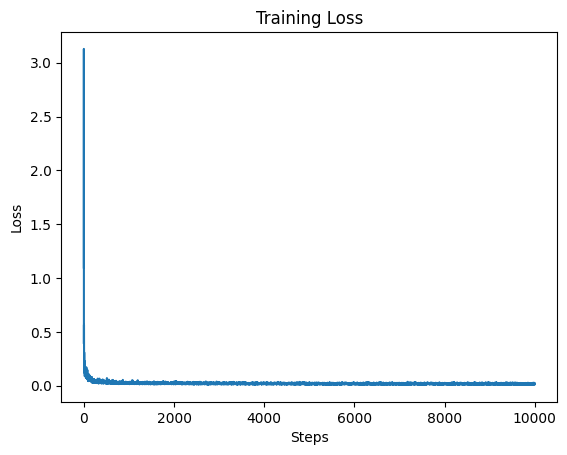

In [7]:
def train_diffusion(n_steps=10000, batch_size=64, lr=1e-3):
    """Train the diffusion model on MNIST data."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize MNIST diffusion model with convolutional architecture.
    model = DiffusionModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize noise scheduler.
    scheduler = DiffusionScheduler(device=device)

    losses = []
    pbar = tqdm(range(n_steps), desc="Training Diffusion")

    for step in pbar:
        # Get a batch of MNIST images.
        x_0 = generate_mnist(batch_size).to(device)
        # Sample random timesteps for the batch.
        t = torch.randint(0, scheduler.num_timesteps, (x_0.shape[0],)).to(device)
        # Apply forward process: add noise.
        x_t, noise = scheduler.diffuse(x_0, t)
        # Predict the noise using the model.
        predicted_noise = model(x_t, t.float() / scheduler.num_timesteps)
        # Compute loss (MSE between the predicted noise and the actual noise).
        loss = torch.mean((predicted_noise - noise) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item()})

    return model, losses, scheduler, device

# Train with a modest number of steps for demonstration:
model, losses, scheduler, device = train_diffusion()

## Visualizing Training Loss
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## Generating Samples from the Trained Model

We now generate MNIST samples from noise and visualize them in a grid.

Sampling: 100%|██████████| 2000/2000 [00:23<00:00, 86.78it/s]


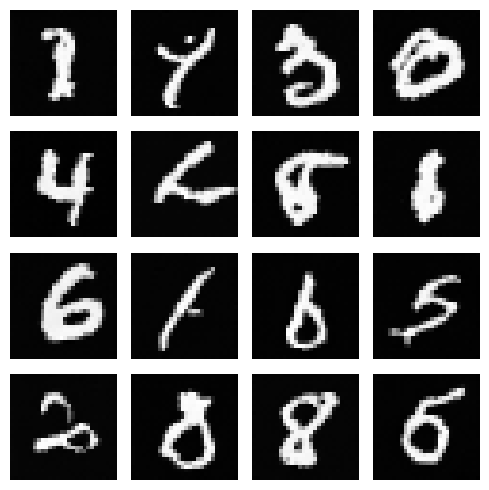

In [8]:
def generate_samples(model, scheduler, n_samples=16):
    """Generate MNIST samples from noise using the reverse process."""
    device = next(model.parameters()).device
    model.eval()

    # Start from random noise.
    x = torch.randn(n_samples, 1, 28, 28).to(device)

    with torch.no_grad():
        for step in tqdm(range(scheduler.num_timesteps-1, -1, -1), desc="Sampling"):
            t = torch.full((n_samples,), step, device=device, dtype=torch.long)
            predicted_noise = model(x, t.float() / scheduler.num_timesteps)
            x = scheduler.reverse_step(x, step, predicted_noise)

    # Denormalize images from [-1, 1] to [0, 1].
    x = (x + 1) / 2
    return x.cpu()

def visualize_samples(samples, nrow=4):
    """Visualize generated samples in a grid."""
    plt.figure(figsize=(5, 5))
    for i in range(len(samples)):
        plt.subplot(nrow, nrow, i+1)
        plt.imshow(samples[i, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate and display samples.
samples = generate_samples(model, scheduler)
visualize_samples(samples)


## Visualizing Forward & Reverse Processes

The following functions help you visualize:
- **Forward Process:** How images get noisier.
- **Reverse Process:** How noise is gradually denoised into images.

Note: In the forward process, we use `generate_mnist` (instead of an undefined `load_mnist`).

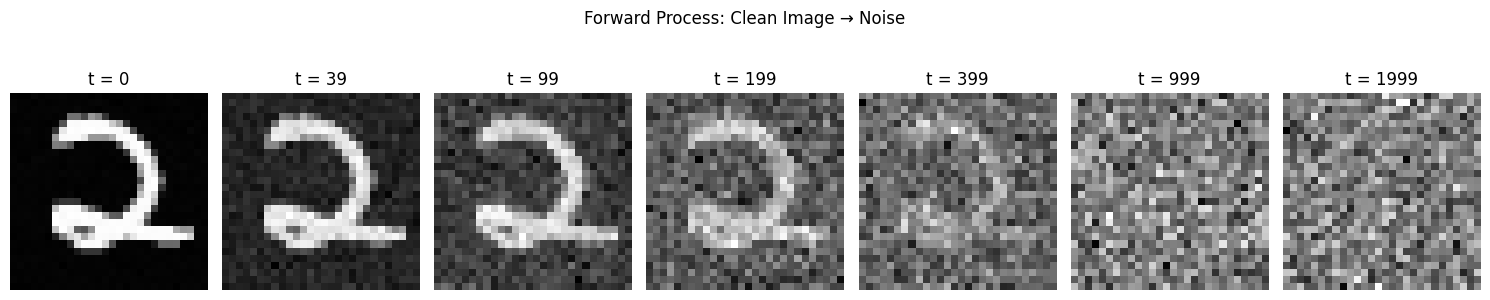

Sampling: 100%|██████████| 2000/2000 [00:22<00:00, 87.36it/s]


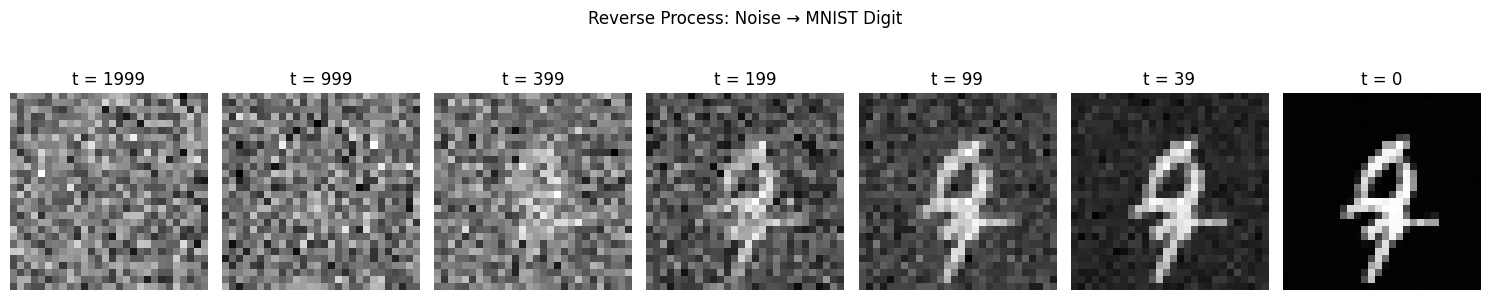

In [9]:
def visualize_forward_process(model, scheduler, n_samples=16):
    """
    Visualize how MNIST digits get progressively noisier in the forward process.
    """
    device = next(model.parameters()).device

    # Generate initial clean images.
    x_0 = generate_mnist(n_samples).to(device)

    max_timestep = scheduler.num_timesteps - 1
    plot_steps = [int(t) for t in [0, max_timestep*0.02, max_timestep*0.05,
                                   max_timestep*0.1, max_timestep*0.2, max_timestep*0.5, max_timestep]]

    fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 3))

    for idx, t in enumerate(plot_steps):
        timesteps = torch.full((n_samples,), t, device=device, dtype=torch.long)
        x_t, _ = scheduler.diffuse(x_0, timesteps)

        ax = axes[idx]
        # Display the first image of the batch at the selected timestep.
        img = x_t[0].detach().cpu()
        ax.imshow(img[0], cmap='gray')
        ax.set_title(f't = {t}')
        ax.axis('off')

    plt.suptitle('Forward Process: Clean Image → Noise', y=1.05)
    plt.tight_layout()
    plt.show()

def visualize_reverse_process(model, scheduler, n_samples=16):
    """
    Visualize the reverse process: the gradual denoising of noise into an MNIST digit.
    """
    device = next(model.parameters()).device

    x = torch.randn(n_samples, 1, 28, 28).to(device)

    max_timestep = scheduler.num_timesteps - 1
    plot_steps = [int(t) for t in [max_timestep, max_timestep*0.5, max_timestep*0.2,
                                   max_timestep*0.1, max_timestep*0.05, max_timestep*0.02, 0]]

    fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 3))

    with torch.no_grad():
        for step in tqdm(range(scheduler.num_timesteps-1, -1, -1), desc="Sampling"):
            t = torch.full((n_samples,), step, device=device, dtype=torch.long)
            predicted_noise = model(x, t.float() / scheduler.num_timesteps)
            x = scheduler.reverse_step(x, step, predicted_noise)

            if step in plot_steps:
                idx = plot_steps.index(step)
                ax = axes[idx]
                img = x[0].detach().cpu()
                ax.imshow(img[0], cmap='gray')
                ax.set_title(f't = {step}')
                ax.axis('off')

    plt.suptitle('Reverse Process: Noise → MNIST Digit', y=1.05)
    plt.tight_layout()
    plt.show()

# Visualize forward process:
visualize_forward_process(model, scheduler)

# Visualize reverse process:
visualize_reverse_process(model, scheduler)

## Comparing Real and Generated MNIST Samples

Display real MNIST digits (from the generator) side-by-side with the generated samples.

Sampling: 100%|██████████| 2000/2000 [00:22<00:00, 87.17it/s]


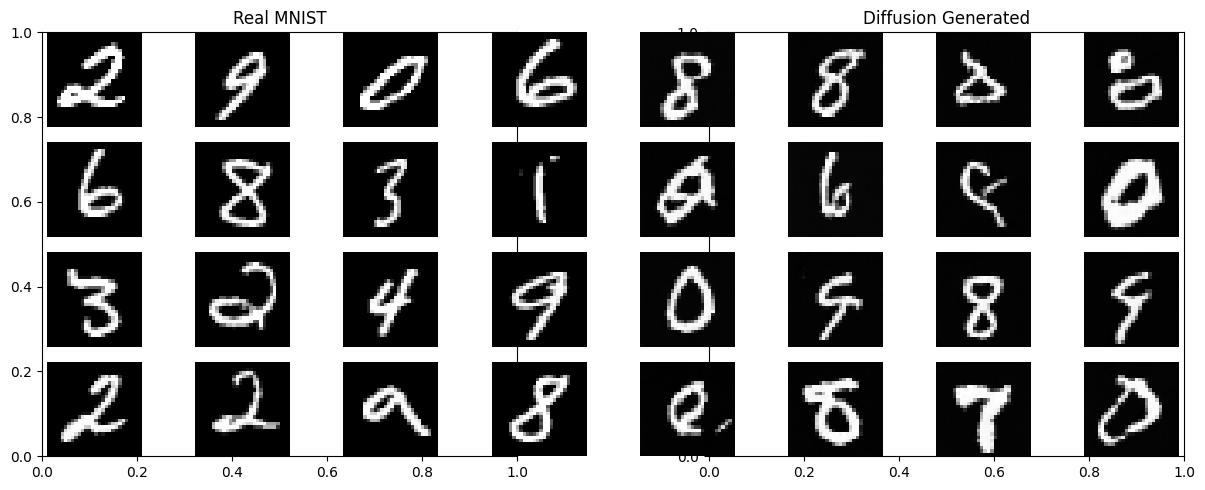

In [10]:
plt.figure(figsize=(12, 5))

# Plot real MNIST data.
plt.subplot(1, 2, 1)
real_data = generate_mnist(16)  # Fetch 16 real MNIST images.
plt.title('Real MNIST')
grid_size = int(np.sqrt(16))  # 4x4 grid.
for i in range(16):
    row = i // grid_size
    col = i % grid_size
    plt.subplot2grid((4, 8), (row, col))
    plt.imshow(real_data[i, 0], cmap='gray')
    plt.axis('off')

# Plot generated MNIST samples.
plt.subplot(1, 2, 2)
samples = generate_samples(model, scheduler, 16)
plt.title('Diffusion Generated')
for i in range(16):
    row = i // grid_size
    col = i % grid_size
    plt.subplot2grid((4, 8), (row, col + 4))  # Offset columns for side-by-side view.
    plt.imshow(samples[i, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Your `To-Do`
 - Can you get the generated numbers closer to the real data?
 - Hint: Try increasing the number of timesteps in diffusion process. You can also try increasing the training steps, maybe play with the architecture a bit ...

Put your modified code, and images that show your improved samples, in a new cell below.

For extra credit, try adapting a GAN, VAE, Flow matching, or RealNVP to generate MNIST.